# Cuaderno 27: Formulación de planos cortantes para el ATSP
## Implementación con planos cortantes

$\newcommand{\card}[1]{\left| #1 \right|}$
$\newcommand{\tabulatedset}[1]{\left\{ #1 \right\}}$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\RR}{\mathbb{R}}$

Dados: 
* un grafo dirigido **completo** $D=(V,A)$; y,
* un vector $c \in \ZZ^{A}$ de costos asociados a los arcos de $D$.

El *problema del agente viajero asimétrico (Asymmetric Traveling Salesman Problem, ATSP)* consiste en encontrar un circuito dirigido que visite **todos** los nodos de $G$ y que tenga el menor costo posible.

Vamos a considerar la formulación como programa lineal entero para el ATSP que emplea desigualdades de cortes para eliminar subciclos (ver Cuaderno 22):

\begin{align*}
\min &\sum_{(i,j) \in A} c_{ij} x_{ij}\\ 
& \mbox{s.r.}\\
&\sum_{(i,j) \in \delta^{+}(i) } x_{ij} = 1, \quad \forall i \in V,\\
&\sum_{(j,i) \in \delta^{-}(i) } x_{ji} = 1, \quad \forall i \in V,\\
&\sum_{ij \in \delta^{+}(W)} x_{ij} \geq 1, \quad \forall W \subset V, \emptyset \neq W \neq V,\\
& x_{ij} \in \{0, 1\}, \quad \forall (i,j) \in A,
\end{align*}
donde $\delta^{+}(W) := \{ (i,j) \in A \, : \, i \in W, j \not\in W\}$.

El problema de esta formulación es la gran cantidad de desigualdades de corte requeridas. Sin embargo, este modelo puede resolverse eficientemente utilizando un **algoritmo de planos cortantes**, el mismo que consiste en generar dinámicamente las desigualdades de corte, conforme sean requeridas en la solución del modelo.

En este cuaderno vamos a revisar cómo implementar un algoritmo de planos cortantes empleando la interfaz Python de Gurobi.



Definimos primero los datos. Usaremos la función `randint` del módulo random para generar valores aleatorios en el rango {0,..,100} para las coordenadas de cada nodo. Los costos de los arcos serán iguales a las distancias euclideanas entre sus nodos extremos. 

In [11]:
from gurobipy import *
import random as rm
import math 

# iniciar generador de numeros aleatorios
rm.seed(0)

# Numero de nodos del grafo
n = 70

# Nodos del grafo
V = tuplelist(range(1,n+1))

# Posiciones de los nodos en un plano euclideano entre (0,0) y (100, 100)
coordx={i : rm.randint(0,100) for i in V}
coordy={i : rm.randint(0,100) for i in V}

# los costos son las distancias eculideanas
c = tupledict({
    (i,j) : math.sqrt((coordx[i] - coordx[j])**2 + (coordy[i] - coordy[j])**2)
    for i in V for j in V if i!=j
})
A = c.keys()


Emplearemos el módulo `matplotlib` para graficar el tour de la solución. Definiremos para ello la función `dibujarTour` que recibe tres argumentos: una lista `coordx` con las coordenadas horizontales de los nodos, una lista `coordy` con las coordenadas verticales y un vector `tour` con una permutación de los nodos indicando el orden de visita en la solución.

In [12]:
import matplotlib.pyplot as plt
import random

def dibujarTour(coordx, coordy, tour):
    x = [coordx[i] for i in tour]
    y = [coordy[i] for i in tour]
    plt.figure(figsize=(15, 15))
    plt.plot(x, y, 'ro')
    Tx = [coordx[i] for i in tour]
    Ty = [coordy[i] for i in tour]
    Tx.append(coordx[tour[0]])
    Ty.append(coordy[tour[0]])
    plt.plot(Tx, Ty, 'b-')
    plt.show()

Definimos ahora el objeto modelo, las variables y la función objetivo. 

Definimos las variables miembro `_x`, `_V` y `_A` dentro del objeto modelo para tener acceso a las variables de selección de arcos, la lista de nodos y la lista de arcos desde la función que se encargará de generar las restricciones de corte. 

In [13]:
# Crear el objeto modelo
m = Model('atsp-corte-lazy')

# Crear las variables
x = m.addVars(A, name="x", vtype=GRB.BINARY)

# Crear la funcion objetivo
m.setObjective(x.prod(c,'*'), GRB.MINIMIZE)

# Crear variables en el objeto modelo para tener acceso a x, V y A
m._x = x
m._V = V
m._A = A

Añadimos las restricciones de grado. 

In [14]:
# Restricciones de grado saliente
m.addConstrs((x.sum(i,'*') == 1 for i in V), "g_saliente")

# Restricciones de grado entrante
m.addConstrs((x.sum('*', i) == 1 for i in V), "g_entrante")



{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>,
 22: <gurobi.Constr *Awaiting Model Update*

Definimos una función callback para separar dinámicamente las restricciones de corte. Esta función es invocada automáticamente por Gurobi cada vez que el solver encuentra una nueva solución entera que satisface las restricciones de grado (`where == GRB.Callback.MIPSOL`). 

La función implementa un algoritmo de marcaje para determinar el conjunto W de todos los nodos que pueden ser alcanzados desde el nodo 1. Si este conjunto es distinto de V, el mismo está asociado a una desigualdad de corte violada por `x`. 

Un algoritmo con estas características se conoce en general como un **algoritmo de separación**: se encarga de verificar que una solución satisfaga todas las desigualdades de una familia o encontrar una desigualdad que sea violada por la solución.

Notar que para acceder a las variables de selección de arcos, la lista de nodos y la lista de arcos, es necesario emplear las variables miembro `_x`, `_V`y `_A` de la clase modelo.

In [15]:
# Funcion callback para separar desigualdades de corte
def mycallback(model, where):
    # Esta funcion se activara cuando se encuentre una nueva solucion entera
    if where == GRB.Callback.MIPSOL:
        # Recuperar los valores de la solucion actual
        vx = model.cbGetSolution(model._x)
        # Determinar los arcos seleccionados en la solucion
        L = [(i,j) for (i,j) in model._A if vx[i,j]>=0.9]
        # Construir la lista W de nodos que pueden ser alcanzados desde 1
        W = [1]
        i = 1
        while True :
            N = [k for k in model._V if (i,k) in L]
            if len(N)>1:
                print("Error en desigualdad de grado:")
                for k in N:
                    print("{}-->{}: {}".format(i,k, vx[i,k]))
            j = N.pop()
            a = (i,j) 
            L.remove(a)
            if j==1: break
            W.append(j)
            i = j
        # Si W!=V, agregar la desigualdad de corte asociada a W
        if len(W)!=len(model._V):
            Wc = [i for i in model._V if i not in W]
            model.cbLazy(model._x.sum(W, Wc) >= 1)


Escribimos el modelo a un archivo de texto:

In [6]:
# Escribir el modelo a un archivo
m.write('atsp-corte-lazy.lp')


Para poder utilizar restricciones tipo *lazy* en un modelo, debe fijarse el parámetro `LazyConstraints` al valor de 1.

In [16]:
# Configurar Gurobi para usar restricciones lazy
m.Params.LazyConstraints = 1


Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0


Fijamos un límite para el tiempo de cálculo y una tolerancia para la brecha de optimalidad:

In [17]:
# Terminar al alcanzar un Gap del 10%
m.Params.MIPGap = 0.05

# Terminar luego de 180 segundos
m.Params.TimeLimit = 300

Changed value of parameter MIPGap to 0.05
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf


Finalmente, resolvemos el modelo y mostramos la solución, en caso de que se haya encontrado una solución factible (si `m.status` es `GRB.Status.OPTIMAL` o `GRB.Status.SUBOPTIMAL`).

In [18]:
# Se recomienda llamar a update() antes de resolver un modelo que usa restricciones lazy
m.update()

# Calcular la solucion optima
m.optimize(mycallback)

# Escribir la solucion
if ((m.status == GRB.Status.OPTIMAL) or 
   (m.status == GRB.Status.SUBOPTIMAL)):
    # Recuperar los valores de las variables
    vx = m.getAttr('x', x)
    print('\nTour optimo:')
    for i,j in A:
        if vx[i,j] >= 0.9:
            print('{} --> {}'.format(i, j))


Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 140 rows, 4830 columns and 9660 nonzeros
Model fingerprint: 0x82286084
Variable types: 0 continuous, 4830 integer (4830 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.10s
Presolved: 140 rows, 4830 columns, 9660 nonzeros
Variable types: 0 continuous, 4830 integer (4830 binary)

Root relaxation: objective 5.064430e+02, 116 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  508.23046    0   14          -  508.23046      -     -    0s
     0     0  516.55819    0   17          -  516.55819      -     -    1s
     0     2  517.13851    0   34          -  517.13851      -     -    1s
   358   238  540.89963   98   59          -  525.81135     

Si encontramos alguna solución factible, el siguiente fragmento de código nos permite graficarla.

[(1, 3), (2, 13), (3, 5), (4, 16), (5, 14), (6, 2), (7, 10), (8, 15), (9, 11), (10, 8), (11, 1), (12, 7), (13, 19), (14, 20), (15, 6), (16, 18), (17, 12), (18, 17), (19, 9), (20, 4)]


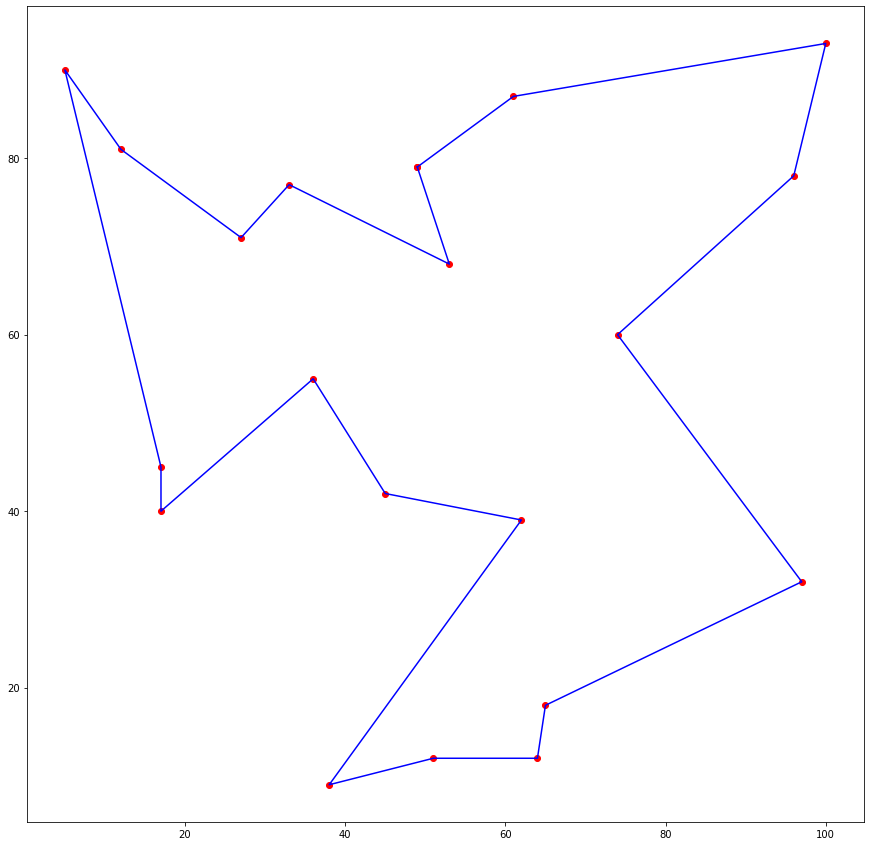

In [10]:
# Crear lista con arcos seleccionados en la solucion
vx = m.getAttr('x', x)
L = [(i,j) for i,j in A if vx[i,j]>0.1]
print(L)

# Recuperar el tour como un ordenamiento de los nodos
T = [1]
# nodo actual:
i = 1
while True:
    # Determinar sucesor de i
    N = [j for j in V if (i,j) in L]
    j = N.pop()
    a = (i,j) 
    L.remove(a)
    # Colocar sucesor en la lista del tour y actualizar i
    T.append(j)
    i = j
    # Terminar cuando el nodo colocado sea 1
    if i==1: break;
        
# Graficar el tour
dibujarTour(coordx, coordy, T)    

### Limitaciones:

Como los planos cortantes se generan solamente cuando hay una solución entera, este método no consigue actualizar con suficiente frecuencia las cotas inferiores y la exploración del árbol de branch-and-bound se torna ineficiente. Necesitamos un método que nos permita separar restricciones de corte a partir de una solución fraccionaria, para poder aplicarlo en cada nodo del árbol de branch-and-bound.

El problema de separar restricciones de corte a partir de una solución fraccionaria no es tan sencillo, pero puede reducirse a un problema de optimización combinatoria conocido: encontrar un corte de capacidad mínima en un grafo. El siguiente ejemplo ilustra una idea.

In [19]:
import networkx as nx
import ipycytoscape

# Ejemplo de solución fraccionaria del TSP
# Nodos del grafo
V = tuplelist(range(1,7))

# Arcos (grafo completo)
A = [(i,j) for i in V for j in V if i!=j]

# Valores de las variables en la solución fraccionaria
A1 = [(1,2), (3,1), (6,4), (5,6)]
A2 = [(2,3), (2,5), (4,3), (4,5)]
A3 = [(i,j) for (i,j) in A if (i,j) not in A1+A2 and (j,i) not in A1+A2]
A = A1+A2+A3
x={(i,j) : 1 if (i,j) in A1 else (0.5 if (i,j) in A2 else 0) for (i,j) in A}

D = nx.DiGraph()
D.add_nodes_from(V)
for i in V:
    D.nodes[i]['etiq']= str(i)
D.add_edges_from(A)
for i,j in A:
    D.edges[i,j]['etiq'] = str(x[i,j]) if x[i,j]>0.1 else ''
    D.edges[i,j]['color'] =  '#0000ff' if x[i,j]>=0.9 else ('#ff007f' if x[i,j]>=0.4 else '#e0e0e0')
grafo = ipycytoscape.CytoscapeWidget()
grafo.graph.add_graph_from_networkx(D, directed=True)
grafo.set_style([{'selector': 'node', 'style' : {'width': 15, 'height' : 15, 'background-color': '#11479e', 'font-family': 'helvetica', 'font-size': '10px', 'color':'white', 'label': 'data(etiq)', 'text-wrap' : 'wrap', 'text-valign' : 'center'}}, 
                    {'selector': 'node:parent', 'css': {'background-opacity': 0.333}, 'style' : {'font-family': 'helvetica', 'font-size': '10px', 'label': 'data(etiq)'}}, 
                    {'selector': 'edge', 'style': {'width': 1, 'line-color': 'data(color)', 'font-size': '10px', 'label': 'data(etiq)', 'text-valign' : 'top', 'text-margin-y' : '-10px'}}, 
                    {'selector': 'edge.directed', 'style': {'curve-style': 'bezier', 'target-arrow-shape': 'triangle', 'target-arrow-color': 'data(color)'}}])
grafo

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'style': {'width': 15…

## Código completo

Se reproduce a continuación el código completo del modelo anterior.

Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter TimeLimit to 180.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 40 rows, 380 columns and 760 nonzeros
Model fingerprint: 0xcb500b63
Variable types: 0 continuous, 380 integer (380 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 40 rows, 380 columns, 760 nonzeros
Variable types: 0 continuous, 380 integer (380 binary)

Root relaxation: objective 2.572960e+02, 30 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  315.1877

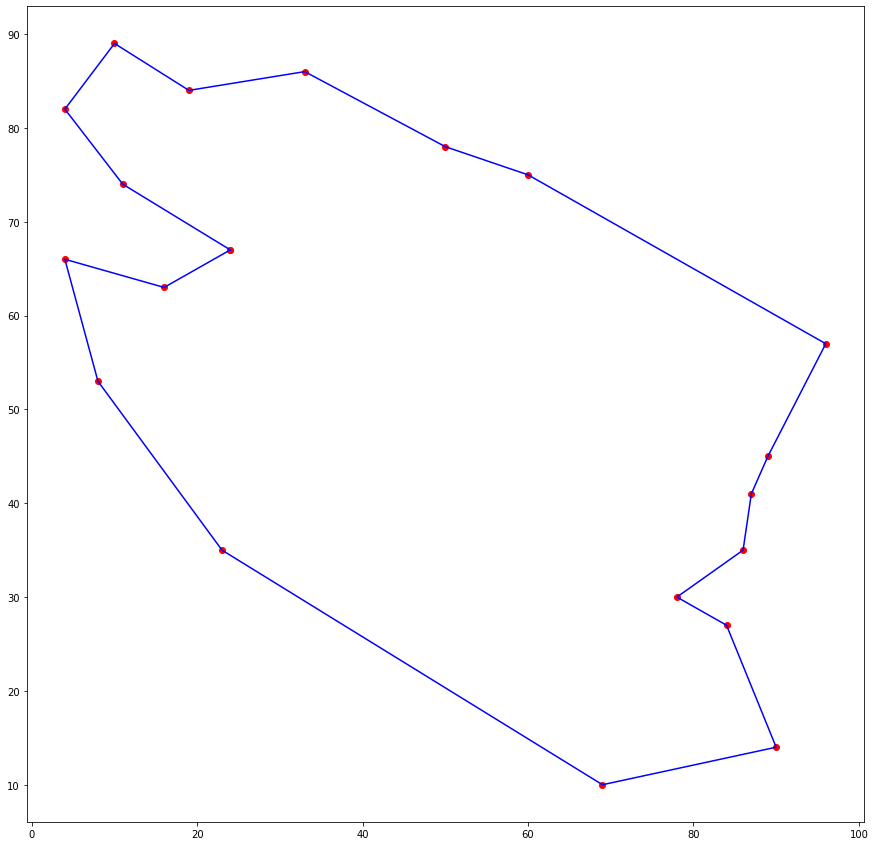

In [24]:
# Implementación de modelos lineales enteros
# Problema del agente viajero asimétrico (ATSP)
# Implementación con desigualdades lazy

# Luis M. Torres (EPN 2020)

from gurobipy import *
import random as rm
import matplotlib.pyplot as plt

def dibujarTour(coordx, coordy, tour):
    x = [coordx[i] for i in tour]
    y = [coordy[i] for i in tour]
    plt.figure(figsize=(15, 15))
    plt.plot(x, y, 'ro')
    Tx = [coordx[i] for i in tour]
    Ty = [coordy[i] for i in tour]
    Tx.append(coordx[tour[0]])
    Ty.append(coordy[tour[0]])
    plt.plot(Tx, Ty, 'b-')
    plt.show()

# Funcion callback para la separacion de restricciones de corte
def mycallback(model, where):
    # Esta funcion se activara cuando se encuentre una nueva solucion entera
    if where == GRB.Callback.MIPSOL:
        # Recuperar los valores de la solucion actual
        vx = model.cbGetSolution(model._x)
        # Determinar los arcos seleccionados en la solucion
        L = [(i,j) for (i,j) in model._A if vx[i,j]>=0.9]
        # Construir la lista W de nodos que pueden ser alcanzados desde 1
        W = [1]
        i = 1
        while True :
            N = [k for k in model._V if (i,k) in L]
            if len(N)>1:
                print("Error en desigualdad de grado:")
                for k in N:
                    print("{}-->{}: {}".format(i,k, vx[i,k]))
            j = N.pop()
            a = (i,j) 
            L.remove(a)
            if j==1: break
            W.append(j)
            i = j
        # Si W!=V, agregar la desigualdad de corte asociada a W
        if len(W)!=len(model._V):
            Wc = [i for i in model._V if i not in W]
            model.cbLazy(model._x.sum(W, Wc) >= 1)
    
# Numero de nodos del grafo
n = 20

# Nodos del grafo
V = tuplelist(range(1,n+1))

# Posiciones de los nodos en un plano euclideano entre (0,0) y (100, 100)
coordx={i : rm.randint(0,100) for i in V}
coordy={i : rm.randint(0,100) for i in V}

# los costos son las distancias eculideanas
c = tupledict({
    (i,j) : math.sqrt((coordx[i] - coordx[j])**2 + (coordy[i] - coordy[j])**2)
    for i in V for j in V if i!=j
})
A = c.keys()

try:
    # Crear el objeto modelo
    m = Model('atsp-corte-lazy')

    # Crear las variables
    x = m.addVars(A, name="x", vtype=GRB.BINARY)

    # Crear la funcion objetivo
    m.setObjective(x.prod(c,'*'), GRB.MINIMIZE)

    # Crear variables en el objeto modelo para tener acceso a x, V y A
    m._x = x
    m._V = V
    m._A = A

    # Restricciones de grado saliente
    m.addConstrs((x.sum(i,'*') == 1 for i in V), "g_saliente")

    # Restricciones de grado entrante
    m.addConstrs((x.sum('*', i) == 1 for i in V), "g_entrante")

    # Escribir el modelo a un archivo
    # m.write('atsp-corte-lazy.lp')

    # Configurar Gurobi para usar restricciones lazy
    m.Params.LazyConstraints = 1

    # Terminar al alcanzar un Gap del 10%
    m.Params.MIPGap = 0.1

    # Terminar luego de 180 segundos
    m.Params.TimeLimit = 180

    # Se recomienda llamar a update() antes de resolver un modelo que usa restricciones lazy
    m.update()

    # Calcular la solucion optima
    m.optimize(mycallback)

    # Escribir la solucion
    if ((m.status == GRB.Status.OPTIMAL) or 
       (m.status == GRB.Status.SUBOPTIMAL)):
        # Recuperar los valores de las variables
        vx = m.getAttr('x', x)
        print('\nTour optimo:')
        for i,j in A:
            if vx[i,j] > 0:
                print('{} --> {}'.format(i, j))

        # Recuperar el tour como un ordenamiento de los nodos
        L = [(i,j) for i,j in A if vx[i,j]>=0.9]
        T = [1]
        i = 1
        while True:
            # Determinar sucesor de i
            N = [j for j in V if (i,j) in L]
            j = N.pop()
            a = (i,j) 
            L.remove(a)
            # Colocar sucesor en la lista del tour y actualizar i
            T.append(j)
            i = j
            # Terminar cuando el nodo colocado sea 1
            if i==1: break;
        # Graficar el tour
        dibujarTour(coordx, coordy, T)        
        
except GurobiError as e:
    print('Se produjo un error de Gurobi: codigo: ' + str(e.errno) + ": " + str(e))

except AttributeError:
    print('Se produjo un error de atributo')